In [14]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.auto import tqdm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
df = pd.read_csv('C:/Users/under/Desktop/karpov_courses/hw_aa.csv', sep=';')

Посмотрим на данные.

In [3]:
df

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...,...
127013,127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127014,127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127015,127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127016,127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


In [4]:
df.dtypes

Unnamed: 0            int64
uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

In [24]:
df.experimentVariant.value_counts()

1    63916
0    63102
Name: experimentVariant, dtype: int64

In [27]:
round(df.experimentVariant.value_counts()[0] / (df.experimentVariant.value_counts()[0] + \
                                                df.experimentVariant.value_counts()[1]), 3)

0.497

In [6]:
df.version.value_counts()

v2.8.0      82835
v2.9.0      23954
v3.8.0.0    11804
v3.7.4.0     8425
Name: version, dtype: int64

In [7]:
df.purchase.value_counts()

0    122104
1      4914
Name: purchase, dtype: int64

In [8]:
df.uid.nunique()

127018

Итого имеем 127018 уникальных пользователей, с разбивкой на контрольную и тестовую группы 50 на 50

In [9]:
# Объявим функцию
def a_a_test(
            df = df,
            simulations = 1000,
            sample_volume = 1000
            ):
    res = []
    # Запуск симуляций A/A теста
    for i in tqdm(range(simulations)):
        s1 = df[df['experimentVariant'] == 1].purchase.sample(sample_volume, replace = False).values
        s2 = df[df['experimentVariant'] == 0].purchase.sample(sample_volume, replace = False).values
        res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue
        
    plt.hist(res, bins = 50)
    plt.style.use('ggplot')
    plt.xlabel('pvalues')
    plt.ylabel('frequency')
    plt.title("Histogram of ttest A/A simulations ")
    plt.show()

    # Проверяем, что количество ложноположительных случаев не превышает альфа
    return sum(np.array(res) <0.05) / simulations

  0%|          | 0/10000 [00:00<?, ?it/s]

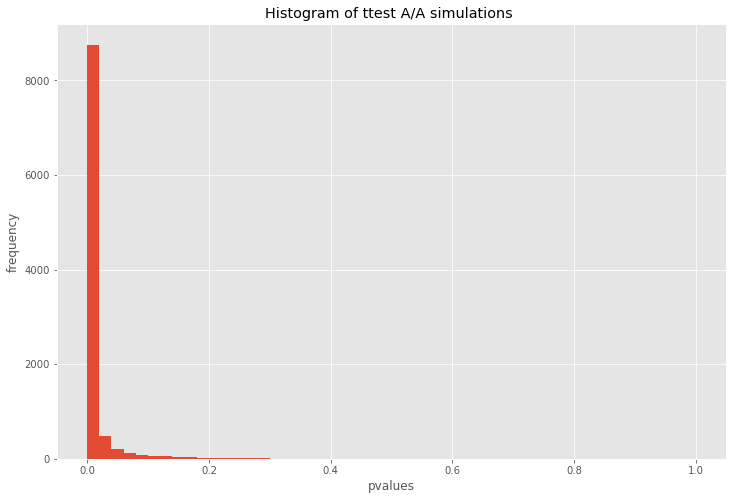

0.9367

In [17]:
a_a_test(simulations=10000)

FFR значительно больше 0.05. Посмотрим более подробно на данные.

In [18]:
df.groupby(['version', 'experimentVariant']).agg({'uid':'count'})

uid
version  experimentVariant       
v2.8.0   0                  41283
         1                  41552
v2.9.0   0                  11921
         1                  12033
v3.7.4.0 0                   4204
         1                   4221
v3.8.0.0 0                   5694
         1                   6110

In [19]:
df.groupby(['version', 'experimentVariant']).agg({'purchase':'sum'})

purchase
version  experimentVariant          
v2.8.0   0                        41
         1                      1895
v2.9.0   0                       890
         1                       858
v3.7.4.0 0                       252
         1                       266
v3.8.0.0 0                       328
         1                       384

Видим явный дисбаланс в количестве фактов покупок в тестовой и контрольной группах версии 2.8.0.  
Проведем АА-тест для каждой отдельно взятой версии.

In [36]:
df_v280 = df.query('version == "v2.8.0"')

  0%|          | 0/10000 [00:00<?, ?it/s]

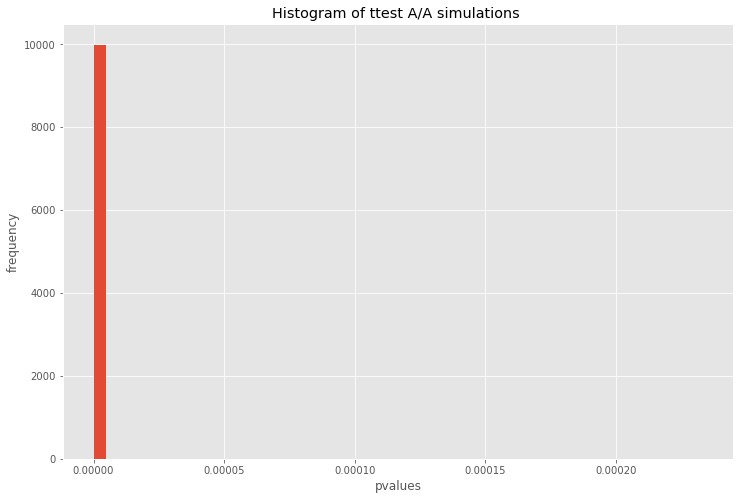

1.0

In [38]:
a_a_test(df=df_v280, simulations=10000)

In [30]:
df_v290 = df.query('version == "v2.9.0"')

  0%|          | 0/10000 [00:00<?, ?it/s]

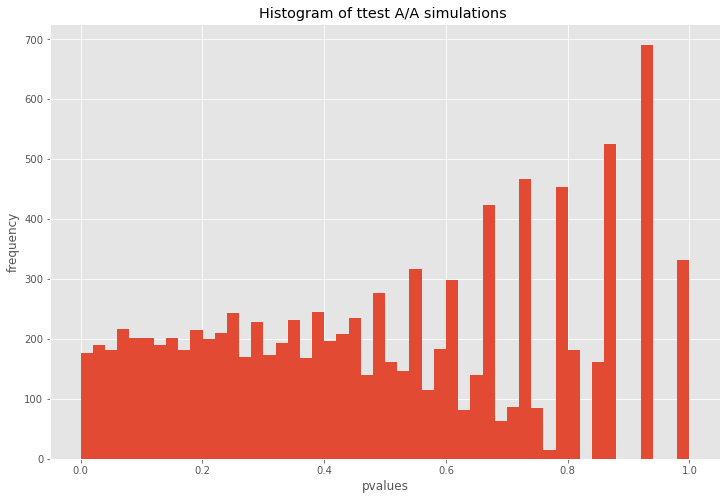

0.0453

In [31]:
a_a_test(df=df_v290, simulations=10000)

In [32]:
df_v3740 = df.query('version == "v3.7.4.0"')

  0%|          | 0/10000 [00:00<?, ?it/s]

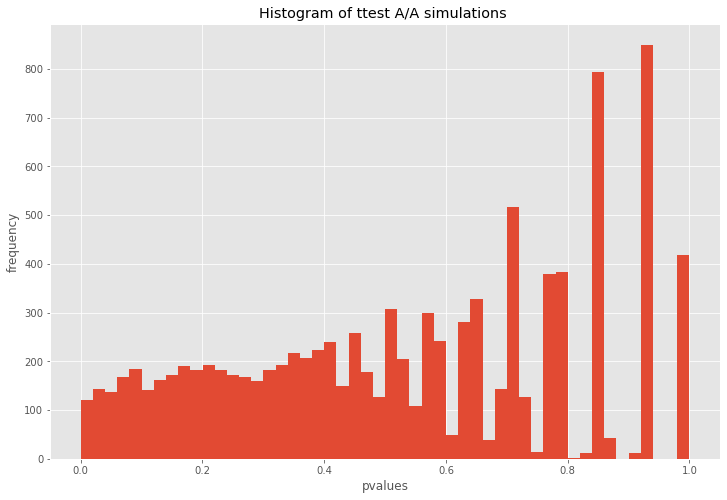

0.0331

In [33]:
a_a_test(df=df_v3740, simulations=10000)

In [34]:
df_v3800 = df.query('version == "v3.8.0.0"')

  0%|          | 0/10000 [00:00<?, ?it/s]

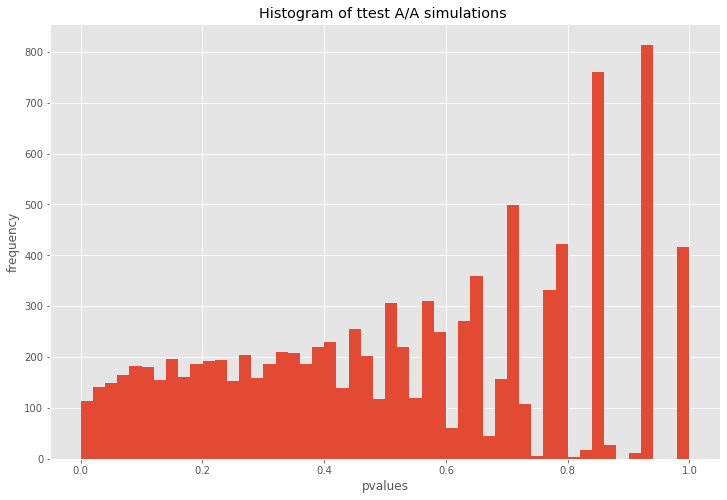

0.033

In [35]:
a_a_test(df=df_v3740, simulations=10000)

Ожидаемо, что версия 2.8.0 пробивает уровен альфа в 0.05. Данную версию мы исключаем из АА-теста.

In [20]:
df_correct = df.query('version != "v2.8.0"')

In [21]:
df_correct.version.value_counts()

v2.9.0      23954
v3.8.0.0    11804
v3.7.4.0     8425
Name: version, dtype: int64

  0%|          | 0/10000 [00:00<?, ?it/s]

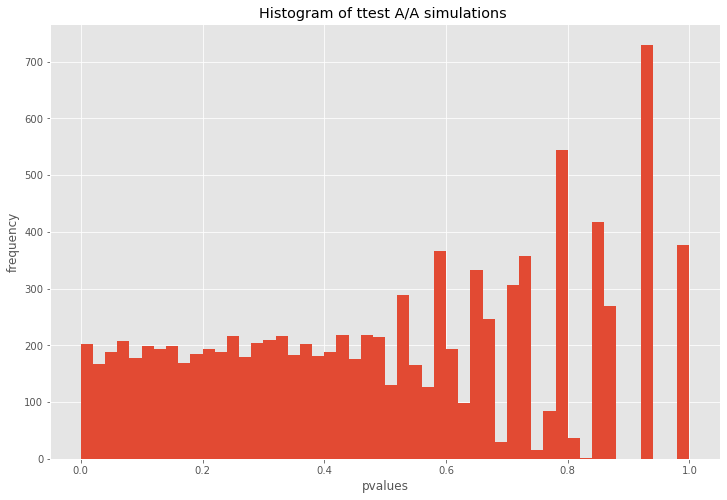

0.046

In [22]:
a_a_test(df=df_correct, simulations=10000)

Теперь наша система сплитования работает корректно.